## Member 2: Exploratory Data Analysis & Visualization 
- Analyze salary distributions across government agencies and job classifications Calculate affordability metrics (30% income-to-housing ratio benchmarks) Identify housing price trends and appreciation rates over time
- Create visualizations: Salary distribution histograms by agency/role, Heat maps of housing prices across DC zip codes Time-series plots of housing appreciation rates, Scatter plots correlating salary levels with affordable zip codes
- Generate insights on current affordability gaps 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set_theme()

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [9]:
salary_path = "DC_Public_Employee_Salary.csv"
housing_path = "DC_housing_prices.csv"

salary_df = pd.read_csv(salary_path)
housing_df = pd.read_csv(housing_path)

salary_df.head()

,FIRST_NAME,LAST_NAME,JOBTITLE,DESCRSHORT,COMPRATE,HIREDATE_STRING,GVT_TYPE_OF_APPT,OBJECTID
0,Scott,Pitzer,Facilities Systems Specialist,DBH,"90,805.00",1987/10/01,CS - Reg,1
1,Pauline,Oboite,NURSE,DBH,"76,510.00",2000/02/14,CS - Reg,2
2,Dawn,Fong,Special Projects Coordinator,DCG,"90,805.00",2020/03/16,CS - Term,3
3,Sonya,Kingsland,Behavioral Health Technician,DBH,"70,600.00",1988/06/07,CS - Reg,4
4,Octavia,Fletcher,Behavioral Health Technician,DBH,"70,600.00",1995/09/18,CS - Reg,5


In [58]:
# Clean salary data a bit

salary_df = salary_df.rename(columns={
    "DESCRSHORT": "AGENCY",
    "JOBTITLE": "JOB_TITLE",
    "COMPRATE": "ANNUAL_SALARY",
    "HIREDATE_STRING": "HIRE_DATE"
})

salary_df["ANNUAL_SALARY"] = pd.to_numeric(salary_df["ANNUAL_SALARY"], errors="coerce")
salary_df = salary_df.dropna(subset=["ANNUAL_SALARY"])

salary_df[["FIRST_NAME", "LAST_NAME", "AGENCY", "JOB_TITLE", "ANNUAL_SALARY"]].head()


,FIRST_NAME,LAST_NAME,AGENCY,JOB_TITLE,ANNUAL_SALARY
0,Scott,Pitzer,DBH,Facilities Systems Specialist,"90,805.00"
1,Pauline,Oboite,DBH,NURSE,"76,510.00"
2,Dawn,Fong,DCG,Special Projects Coordinator,"90,805.00"
3,Sonya,Kingsland,DBH,Behavioral Health Technician,"70,600.00"
4,Octavia,Fletcher,DBH,Behavioral Health Technician,"70,600.00"


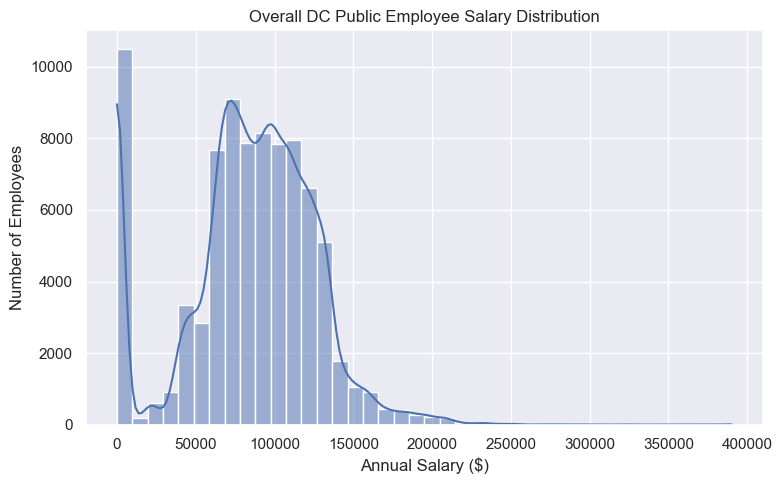

In [64]:
# Overall salary distribution

plt.figure(figsize=(8, 5))
sns.histplot(salary_df["ANNUAL_SALARY"], bins=40, kde=True)
plt.title("Overall DC Public Employee Salary Distribution")
plt.xlabel("Annual Salary ($)")
plt.ylabel("Number of Employees")
plt.tight_layout()
plt.show()

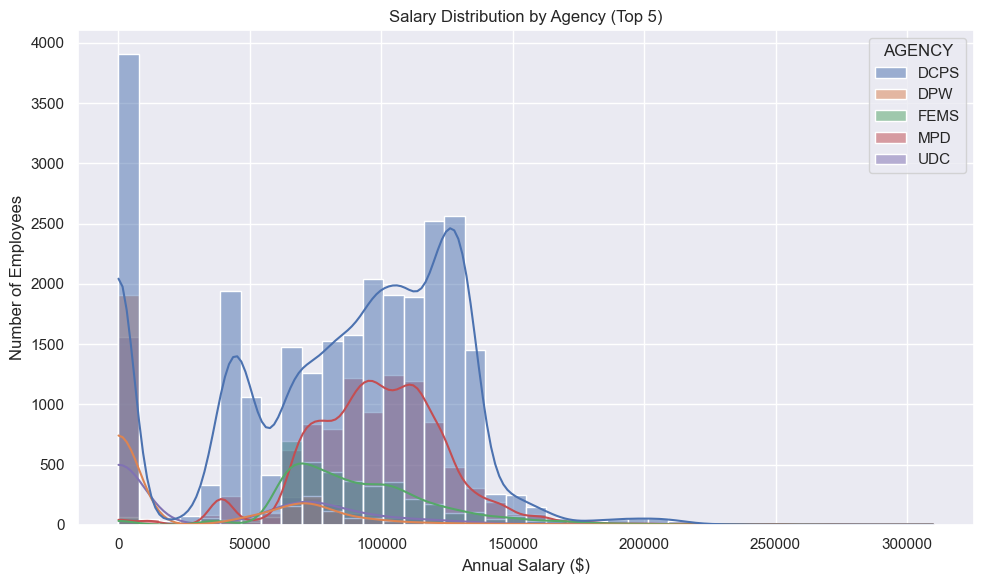

In [66]:
# Salary by top 5 agencies (histogram)

top_agencies = salary_df["AGENCY"].value_counts().head(5).index
top_agency_df = salary_df[salary_df["AGENCY"].isin(top_agencies)]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=top_agency_df,
    x="ANNUAL_SALARY",
    hue="AGENCY",
    bins=40,
    kde=True,
    alpha=0.5
)
plt.title("Salary Distribution by Agency (Top 5)")
plt.xlabel("Annual Salary ($)")
plt.ylabel("Number of Employees")
plt.tight_layout()
plt.show()

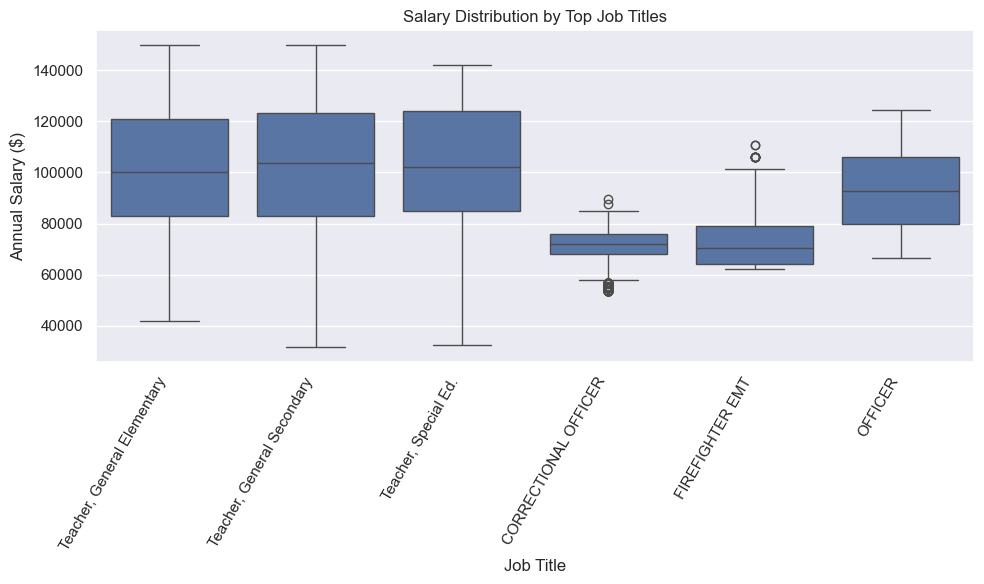

In [68]:
# Salary by top job titles (boxplot)

top_jobs = salary_df["JOB_TITLE"].value_counts().head(6).index
top_jobs_df = salary_df[salary_df["JOB_TITLE"].isin(top_jobs)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=top_jobs_df, x="JOB_TITLE", y="ANNUAL_SALARY")
plt.xticks(rotation=60, ha="right")
plt.title("Salary Distribution by Top Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Annual Salary ($)")
plt.tight_layout()
plt.show()

In [70]:
# Make housing data long (ZIP, DATE, PRICE)

# "RegionName" is the ZIP code
id_col = "RegionName"

date_cols = housing_df.columns[9:]

housing_long = housing_df.melt(
    id_vars=[id_col],
    value_vars=date_cols,
    var_name="DATE_STR",
    value_name="PRICE"
)

# Rename RegionName > ZIP
housing_long = housing_long.rename(columns={"RegionName": "ZIP"})

# Convert date column to real datetime
housing_long["DATE"] = pd.to_datetime(housing_long["DATE_STR"], errors="coerce")

housing_long.head()

/var/folders/st/gkfrd35j0b772pxrp29p97cc0000gn/T/ipykernel_87016/373721655.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  housing_long["DATE"] = pd.to_datetime(housing_long["DATE_STR"], errors="coerce")


,ZIP,DATE_STR,PRICE,DATE
0,20002,1/31/00,"143,758.82",2000-01-31
1,20011,1/31/00,"155,266.45",2000-01-31
2,20019,1/31/00,"102,832.83",2000-01-31
3,20020,1/31/00,"115,353.36",2000-01-31
4,20009,1/31/00,"165,889.60",2000-01-31


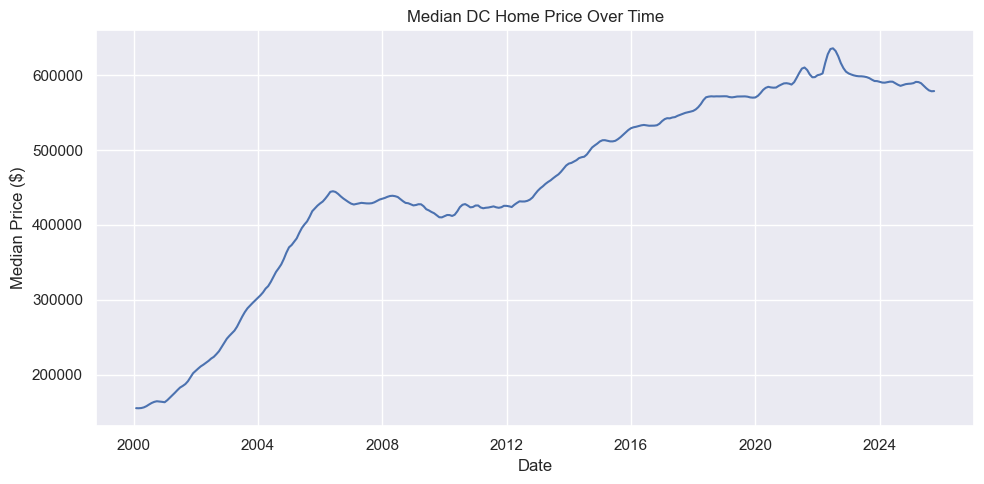

In [72]:
# Median DC home price over time

dc_ts = (
    housing_long
    .groupby("DATE")["PRICE"]
    .median()
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(dc_ts["DATE"], dc_ts["PRICE"])
plt.title("Median DC Home Price Over Time")
plt.xlabel("Date")
plt.ylabel("Median Price ($)")
plt.tight_layout()
plt.show()

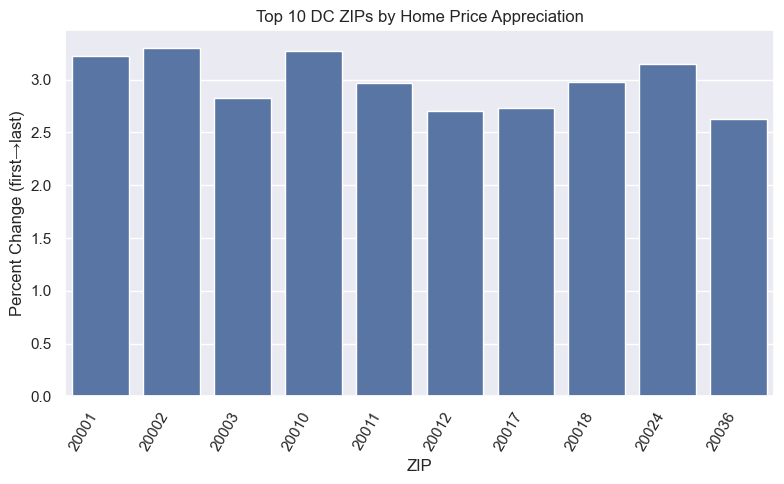

In [74]:
# % change in price by ZIP (first date vs last date)

# Drop missing prices
hl = housing_long.dropna(subset=["PRICE"]).copy()

first_price = hl.sort_values("DATE").groupby("ZIP")["PRICE"].first()
last_price  = hl.sort_values("DATE").groupby("ZIP")["PRICE"].last()

appreciation = (
    (last_price - first_price) / first_price
).reset_index()
appreciation.columns = ["ZIP", "PCT_CHANGE"]

# Top 10 biggest increases
top_up = appreciation.sort_values("PCT_CHANGE", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=top_up, x="ZIP", y="PCT_CHANGE")
plt.xticks(rotation=60, ha="right")
plt.title("Top 10 DC ZIPs by Home Price Appreciation")
plt.ylabel("Percent Change (first→last)")
plt.tight_layout()
plt.show()

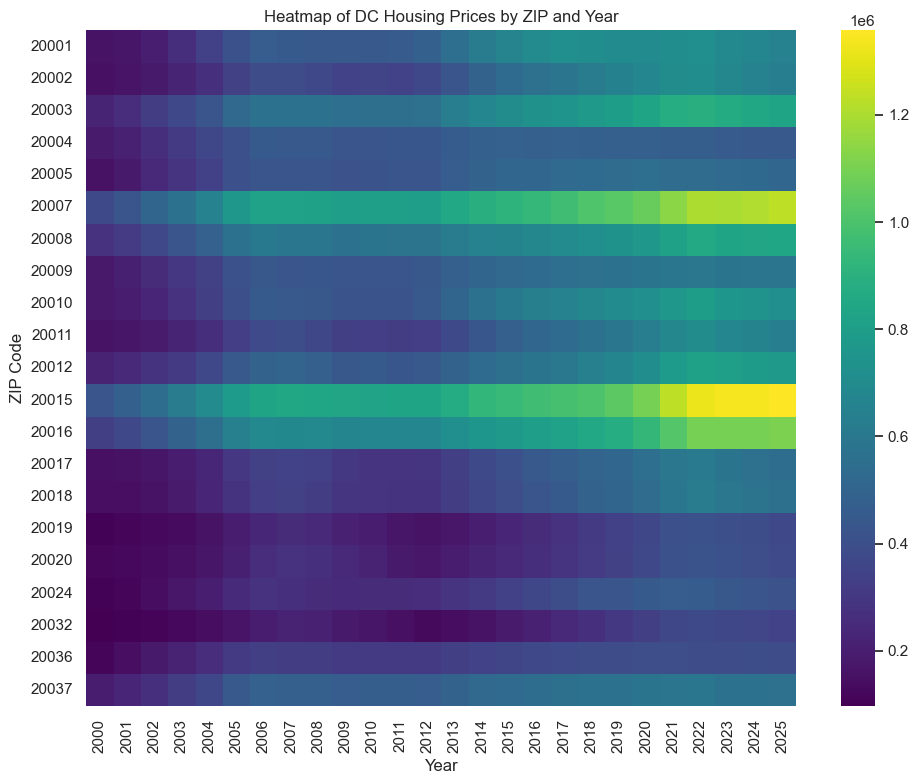

In [76]:
# Heatmap of average price by ZIP & year

housing_long["YEAR"] = housing_long["DATE"].dt.year

avg_price_zip_year = (
    housing_long
    .groupby(["ZIP", "YEAR"])["PRICE"]
    .mean()
    .reset_index()
)

heat_data = avg_price_zip_year.pivot(index="ZIP", columns="YEAR", values="PRICE")

plt.figure(figsize=(10, 8))
sns.heatmap(heat_data, cmap="viridis")
plt.title("Heatmap of DC Housing Prices by ZIP and Year")
plt.xlabel("Year")
plt.ylabel("ZIP Code")
plt.tight_layout()
plt.show()

In [78]:
# Agency median salary and max affordable home price

agency_stats = (
    salary_df
    .groupby("AGENCY")["ANNUAL_SALARY"]
    .median()
    .reset_index()
)

agency_stats = agency_stats.rename(columns={"ANNUAL_SALARY": "MEDIAN_SALARY"})

# Max affordable home price using 30% income and 5% yearly cost
agency_stats["MAX_AFFORDABLE_PRICE"] = 6 * agency_stats["MEDIAN_SALARY"]

agency_stats.head()

,AGENCY,MEDIAN_SALARY,MAX_AFFORDABLE_PRICE
0,ABCA,"98,412.00","590,472.00"
1,ABRA,"95,534.00","573,204.00"
2,ANC,"100,408.50","602,451.00"
3,APIA,"69,481.00","416,886.00"
4,BEGA,"112,628.00","675,768.00"


In [80]:
# Latest DC home prices for each ZIP

latest_date = housing_long["DATE"].max()
housing_latest = housing_long[housing_long["DATE"] == latest_date].copy()

zip_prices = housing_latest[["ZIP", "PRICE"]].dropna()
zip_prices.head()

,ZIP,PRICE
6468,20002,"618,260.87"
6469,20011,"616,076.32"
6470,20019,"363,698.57"
6471,20020,"368,430.07"
6472,20009,"578,906.31"


In [82]:
# How many ZIPs each agency can afford?

affordable_counts = []

for _, row in agency_stats.iterrows():
    max_price = row["MAX_AFFORDABLE_PRICE"]
    count_affordable = (zip_prices["PRICE"] <= max_price).sum()
    affordable_counts.append(count_affordable)

agency_stats["AFFORDABLE_ZIPS"] = affordable_counts

agency_stats.head()

,AGENCY,MEDIAN_SALARY,MAX_AFFORDABLE_PRICE,AFFORDABLE_ZIPS
0,ABCA,"98,412.00","590,472.00",11
1,ABRA,"95,534.00","573,204.00",10
2,ANC,"100,408.50","602,451.00",11
3,APIA,"69,481.00","416,886.00",5
4,BEGA,"112,628.00","675,768.00",14


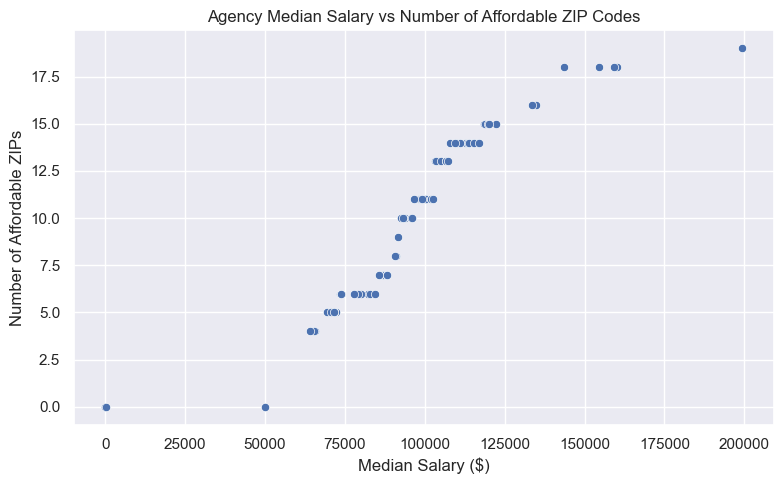

In [84]:
# Scatter plot of salary vs number of affordable ZIPs

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=agency_stats,
    x="MEDIAN_SALARY",
    y="AFFORDABLE_ZIPS"
)
plt.title("Agency Median Salary vs Number of Affordable ZIP Codes")
plt.xlabel("Median Salary ($)")
plt.ylabel("Number of Affordable ZIPs")
plt.tight_layout()
plt.show()

In [86]:
# Check affordable ZIPs for one agency

example_agency = agency_stats["AGENCY"].iloc[0]  # or set manually, e.g. "DCPS"

row = agency_stats[agency_stats["AGENCY"] == example_agency].iloc[0]
max_price = row["MAX_AFFORDABLE_PRICE"]

affordable_zips_example = zip_prices[zip_prices["PRICE"] <= max_price].sort_values("PRICE")

print("Agency:", example_agency)
print("Median salary:", round(row["MEDIAN_SALARY"], 2))
print("Max affordable home price:", round(max_price, 2))
print("\nAffordable ZIPs (latest housing data):")
affordable_zips_example

Agency: ABCA
Median salary: 98412.0
Max affordable home price: 590472.0

Affordable ZIPs (latest housing data):


,ZIP,PRICE
6474,20032,"335,635.93"
6470,20019,"363,698.57"
6471,20020,"368,430.07"
6487,20036,"381,635.97"
6485,20024,"397,740.85"
6488,20004,"438,901.47"
6484,20005,"507,914.48"
6480,20017,"532,215.20"
6481,20018,"547,159.99"
6486,20037,"553,128.34"


## Introduction

The purpose of this analysis is to explore the relationship between DC public employee salaries and housing affordability across Washington, DC. Using two datasets, DC Public Employee Salary data and DC Housing Prices, we examined salary distributions, housing price trends, appreciation rates, and the number of ZIP codes that are affordable for different government agencies. This analysis helps identify which groups have access to affordable housing and highlights areas where affordability gaps exist.

## Key Findings

1. Overall Salary Distribution

Insight:
The salary distribution for DC public employees is highly right-skewed, meaning most employees earn between $50,000 and $120,000, with the peak around $80,000–$100,000. Only a small number of employees earn very high salaries above $150,000, and outliers reach up to $400,000.

Most public workers fall into a typical mid-income range, while only a few senior or specialized roles earn much higher wages. This is important because housing affordability will be more challenging for the majority earning below six figures.

2. Salary Distribution by Agency (Top 5 Agencies)

Insight:
Across the top agencies (DCPS, DPW, FEMS, MPD, UDC), salary levels differ significantly.

DCPS (Public Schools) has the largest employee count with salaries centered around $70,000–$120,000.

MPD (Police Department) and FEMS (Fire & EMS) show salary peaks above $100,000, reflecting overtime and specialized pay.

UDC and DPW tend to cluster in the lower-to-mid ranges.

Agencies such as Police and Fire have higher earning potential, while agencies like DPW and UDC may face more affordability challenges.

3. Salary by Top Job Titles (Boxplot)

Insight:

Teacher roles (Elementary, Secondary, Special Ed) show similar median salaries between $90,000–$110,000, with wide ranges due to varying experience levels.

Correctional Officers and Firefighter EMTs earn noticeably lower median salaries, often between $60,000–$80,000.

Police Officers have slightly higher medians, around $90,000–$100,000.

Even within popular job categories, pay disparities exist. Teachers generally earn more, while EMTs and correctional officers are paid less, meaning EMTs face the greatest housing affordability pressure.

4. Median DC Home Price Over Time

Insight:
DC home prices have steadily increased from around $150,000 in 2000 to $650,000+ by 2024, with small dips around 2008 (financial crisis) and 2020–2021, but overall a strong upward trend.

Housing prices have grown much faster than public employee salaries. This widening gap makes homeownership more out of reach, especially for lower-income agencies.

5. Top 10 ZIP Codes by Home Price Appreciation

Insight:
The ZIP codes with the strongest appreciation include 20001, 20002, 20010, 20024, 20011, consistently showing ~3× price increases from the earliest to latest years.

High-growth ZIPs have become significantly more expensive over time. These areas now require much higher incomes, pushing affordability out of reach for many public workers.

6. Heatmap of Home Prices by ZIP and Year

Insight:
The heatmap visually shows that most ZIP codes have darkened over time, meaning prices increased consistently.
ZIPs such as 20007, 20008, 20015, 20016 became the most expensive, shown by the bright yellow sections in recent years.

Neighborhood-level inequality has grown. Expensive ZIPs continue to get more expensive, further restricting where lower-paid employees can afford to live.

7. Agency Salary vs. Number of Affordable ZIP Codes

Insight:
There is a clear positive relationship between higher median salaries and the number of affordable ZIP codes.

Agencies with median salaries around $60,000–$80,000 can only afford 0–5 ZIP codes.

Agencies with median salaries above $120,000 can afford 15–19 ZIP codes.

Affordability strongly depends on salary. Lower-paid agencies essentially have no affordable housing options in DC, while higher-paid agencies retain far more access. This highlights a structural affordability gap within the workforce.

## Overall Conclusion

Across all analyses, the findings show a consistent gap between salary levels and housing prices in Washington, DC. While home values have sharply increased over the past two decades, salary growth for many government workers has not kept pace. As a result:

Lower-paying agencies face severe housing affordability challenges.

Higher-paying agencies have access to more neighborhoods but still see affordability pressures due to rapid price growth.

The long-term appreciation in ZIPs like 20001, 20010, and 20024 further pushes housing out of reach for mid-income workers.

In short, both datasets together reveal a widening affordability divide that impacts the ability of DC public employees to live in the communities they serve.